In [1]:
import os 
import math
import geopandas as gp
import xarray as xr
import numpy as np
import geopandas as gp
import pandas as pd
import seaborn as sns
sns.set()

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import gridspec
from scipy import interpolate, ndimage
from rasterio import features
from affine import Affine
from geopandas import GeoDataFrame
from netCDF4 import Dataset, num2date
from IPython.display import HTML
from shapely.geometry import Point

# Use the CIMIS stations to query SSEBop ncdf

In [2]:
# Directories
stn_dir = '/Users/aakash/Desktop/CIMIS/dailyStns/'
data_dir = '/Users/aakash/Desktop/CIMIS/data/'

# Find the ET data files and unzip
zipfiles = [os.path.join(stn_dir,x) for x in os.listdir(stn_dir) if x.endswith(".zip")]

outdirs = []
for i in zipfiles:
    print("processing " + os.path.split(i)[1][:-4])
    outdirs.append(os.path.join(data_dir,os.path.split(i)[1][:-4]))
    os.system('''unzip {} -d{}'''.format(i, os.path.join(data_dir,os.path.split(i)[1][:-4])))
    
outdirs.sort()

processing dailyStns2008
processing dailyStns2009
processing dailyStns2018
processing dailyStns2002
processing dailyStns2016
processing dailyStns2017
processing dailyStns2003
processing dailyStns2015
processing dailyStns2001
processing dailyStns2000
processing dailyStns2014
processing dailyStns2010
processing dailyStns2004
processing dailyStns2005
processing dailyStns2011
processing dailyStns2007
processing dailyStns2013
processing dailyStns2012
processing dailyStns2006


Text(0.5, 1.0, 'Cimis record length (years)')

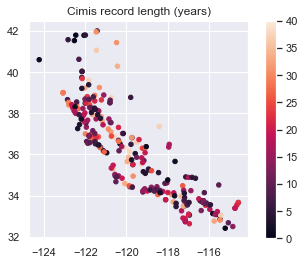

In [3]:
# Read the sites file and make a gdf 
sites = pd.read_excel(os.path.join(data_dir,"cimis_stations.xlsx"))

sdf = sites.copy()

geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
df = sdf.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(sdf, crs=crs, geometry=geometry)


# Get the length of record for each site 

# Convert "active to datetime now"
dt = []
for i in gdf['Disconnect']:
    if i =="Active":
        dt.append(pd.Timestamp.now())
    else:
        dt.append(pd.to_datetime(i))

# Calc time difference 
gdf['Disconnect2'] = dt
reclen = gdf.Connect - gdf.Disconnect2
nyears = [float(x.days / 365) for x in reclen]
gdf['nyears'] = (np.array(nyears)**2)**(1/2)

# Rename the first column of the gdf 
gdfclist = [x for x in gdf.columns]
gdfclist[0] = 'id'
gdf.columns = gdfclist

# Plot
gdf.plot(column = 'nyears', markersize = 20, legend = True, vmin = 0, vmax = 40)
plt.title("Cimis record length (years)")

In [4]:
# Now get the SSEBop et data and join it to CIMIS 
minx, miny, maxx, maxy = gdf.geometry.total_bounds

# Get the ssebop data
comstr = '''curl -o ../data/ssebop.nc https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north={}&west={}&east={}&south={}&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1'''.format(maxy, minx, maxx, miny)
# Run following from command line
print(comstr)


curl -o ../data/ssebop.nc https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=42.003&west=-124.243186&east=-114.558&south=32.411&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1


In browser, go to:

https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=42.003&west=-124.243186&east=-114.558&south=32.411&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1

and run from command line: `mv ~/Downloads/monthly_nc ~/Desktop/CIMIS/data/ssebnop.nc`

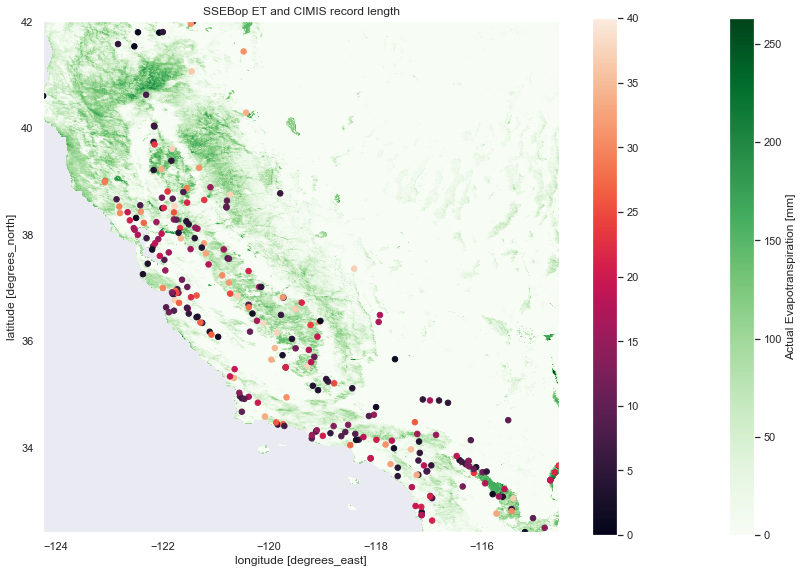

In [5]:
# Find the SSEBop netcdf file and plot a month 

files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])

fig, ax=plt.subplots(figsize = (12,8))
ds['et'][8].plot(ax = ax, cmap = 'Greens')
gdf.plot(column = 'nyears', markersize = 30, legend = True, vmin = 0, vmax = 40, ax = ax)
plt.title("SSEBop ET and CIMIS record length")
plt.tight_layout()

In [6]:
def geo_idx(dd, dd_array):
    """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

# Process the daily CIMIS data to compare with SSEBop 

In [7]:
# Columns after 2014
columns_14_18 = ['id', 'date', 'julian_date', 'ref_eto_qc', 'ref_eto', 'precip_qc','precip', 'srad_qc', 'srad',  'vp_qc', 'vp', 'max_airtemp_qc',  
                 'max_airtemp', 'min_airtemp', 'min_airtemp_qc', 'avg_airtemp_qc','avg_airtemp',  'max_rh_qc','max_rh',  'min_rh_qc', 'min_rh',  
                 'avg_rh_qc', 'avg_rh','dew_pt_qc','dew_pt', 'avg_windspeed', 'avg_windspeed_qc', 'wind_run_qc', 'wind_run',   'avg_soil_temp_qc', 
                 'avg_soil_temp']

# Columns before 2014
columns_00_14 = [ 'id', 'date', 'julian_date', 'srad_qc', 'srad', 'avg_soil_temp_qc', 'avg_soil_temp', 
                 'max_airtemp_qc', 'max_airtemp', 'min_airtemp_qc', 'min_airtemp', 'avg_airtemp_qc', 'avg_airtemp', 'vp_qc','vp', 'avg_windspeed_qc', 
                 'avg_windspeed', 'precip_qc', 'precip', 'max_rh_qc', 'max_rh', 'min_rh_qc', 'min_rh', 'ref_eto_qc', 'ref_eto', 'avg_rh_qc', 'avg_rh',
                 'dew_pt_qc', 'dew_pt', 'wind_run_qc', 'wind_run']


# # These cols are from the Readme
columns_14_18 = ['id', 'date', 'julian_date', 'ref_eto','ref_eto_qc', 'precip', 'precpi_qc', 'srad', 'srad_qc', 'vp', 'vp_qc', 'max_airtemp', 'max_airtemp_qc', 'min_airtemp', 
 'min_airtemp_qc', 'avg_airtemp', 'avg_airtemp_qc', 'max_rh', 'max_rh_qc', 'min_rh', 'min_rh_qc', 'avg_rh', 'avg_rh_qc', 'dew_pt', 'dew_pt_qc', 'avg_windspeed',
          'avg_windspeed_qc', 'wind_run', 'wind_run_qc', 'avg_soil_temp', 'avg_soil']


In [8]:
# Main routine 
all_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = gdf[gdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]

        # Extract lat / long value from SSEBop 
        in_lat = np.array(gdf[gdf.id==i].Latitude)
        in_lon = np.array(gdf[gdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            yr = j.strftime('%Y-%m-%d')
            tempdf = pd.DataFrame([i, yr, cimis_dat[j], ds.sel(time=yr)['et'][lat_idx, lon_idx].values]).T
            tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et']
            outdfs.append(tempdf)
    
    all_dfs.append(pd.concat(outdfs))


Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2000
Processing 104 CIMIS stations for 2000 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2001
Processing 108 CIMIS stations for 2001 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2002
Processing 114 CIMIS stations for 2002 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2003
Processing 113 CIMIS stations for 2003 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2004
Processing 116 CIMIS stations for 2004 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2005
Processing 119 CIMIS stations for 2005 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2006
Processing 121 CIMIS stations for 2006 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2007
Processing 119 CIMIS stations for 2007 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2008
Processing 121 CIMIS stations for 2008 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2009
Processing 123 CIMIS stations for 2009 
Processing /Users/aa

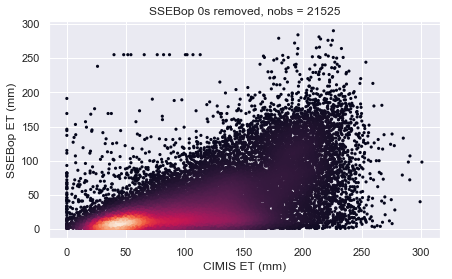

In [57]:
# Scatterplot CIMIS et vs ssebop ET 
dataset = pd.concat(all_dfs)

data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]
valid = valid.loc[valid['ssebop_et'] !=0].dropna()

x,y = valid.cimis_et.astype(float), valid.ssebop_et.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("SSEBop 0s removed, nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

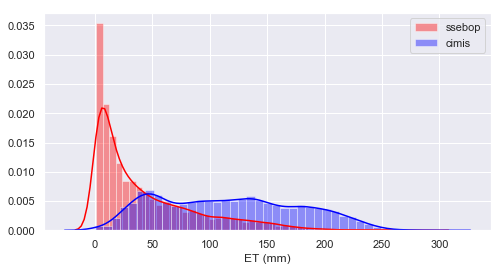

In [55]:
# Plot histograms and distributions

plt.figure(figsize=(8,4))
sns.distplot(valid.ssebop_et.astype(float), color = "red", label = "ssebop")
sns.distplot(valid.cimis_et.astype(float), color= "blue", label = 'cimis')
plt.xlabel("ET (mm)")
plt.legend()
plt.show()


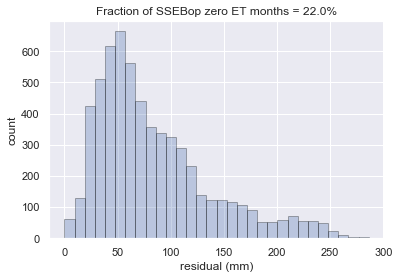

In [11]:
# For days where ssebop ET is zero, plot the corresponding CIMIS et 

ssebop_0 = data.loc[data['ssebop_et'] == 0]
plt.hist(ssebop_0.cimis_et.astype(float), bins = 30, alpha = 0.3, edgecolor='black')
plt.title("Fraction of SSEBop zero ET months = {}%".format(str(round(len(ssebop_0)/len(data),2)*100)))
plt.ylabel("count")
plt.xlabel("residual (mm)")
plt.show()

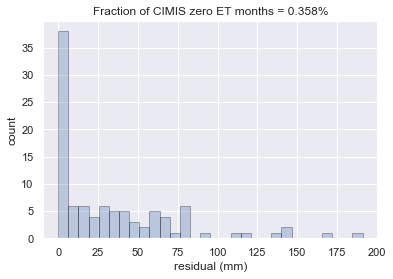

In [12]:
# For days where CIMIS ET is zero, plot the corresponding CIMIS et 

cimis_0 = data.loc[data['cimis_et'] == 0]
plt.hist(cimis_0.ssebop_et.astype(float), bins = 30, alpha = 0.3, edgecolor='black')
plt.title("Fraction of CIMIS zero ET months = {}%".format(str(round(len(cimis_0)/len(data),5)*100)))
plt.ylabel("count")
plt.xlabel("residual (mm)")
plt.show()

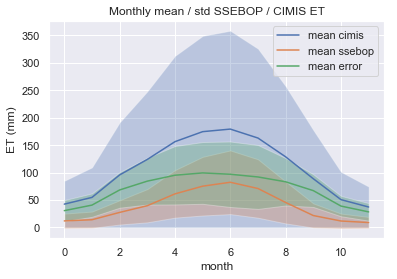

In [58]:
# Calculate the mean monthly error between SSEBop and CIMIS 

dataset = pd.concat(all_dfs)
dataset = dataset.dropna()
dataset = dataset[~np.isnan(dataset.ssebop_et.astype(float))]
dataset = dataset.loc[dataset['ssebop_et'] !=0].dropna()

dataset.date = pd.to_datetime(dataset.date)

monthly_error_mean = []
monthly_error_std =[]
monthly_ssebop_mean = []
monthly_ssebop_std = []
monthly_cimis_mean = []
monthly_cimis_std = []

for i in range(1,13):
    # Select all rows for month i 
    mdf = dataset.loc[dataset['date'].dt.month==i]
    
    # Get cimis / ssebop stats 
    monthly_ssebop_mean.append(np.nanmean(mdf.ssebop_et))
    monthly_ssebop_std.append(np.nanstd(mdf.ssebop_et))
    monthly_cimis_mean.append(np.nanmean(mdf.cimis_et))
    monthly_cimis_std.append(np.nanstd(mdf.cimis_et))
    
    mresid = mdf.cimis_et - mdf.ssebop_et
    monthly_error_mean.append(np.nanmean(mresid))
    monthly_error_std.append(np.nanstd(mresid))

# +- 1 std
upper = np.array(monthly_error_mean) + np.array(monthly_error_std)
lower = np.array(monthly_error_mean) - np.array(monthly_error_std)

cimis_upper = np.array(monthly_cimis_mean) + np.array(monthly_cimis_mean)
cimis_lower = np.array(monthly_cimis_mean) - np.array(monthly_cimis_mean)

ssebop_upper = np.array(monthly_ssebop_mean) + np.array(monthly_ssebop_std)
ssebop_lower = np.array(monthly_ssebop_mean) - np.array(monthly_ssebop_std)


plt.plot(monthly_cimis_mean, label = 'mean cimis')
plt.fill_between(range(0,12),cimis_lower, cimis_upper, alpha = 0.3)

plt.plot(monthly_ssebop_mean, label = 'mean ssebop')
plt.fill_between(range(0,12),ssebop_lower, ssebop_upper, alpha = 0.3)

plt.plot(monthly_error_mean, label = 'mean error')
plt.fill_between(range(0,12),lower, upper, alpha = 0.3)
plt.ylabel("ET (mm)")
plt.title("Monthly mean / std SSEBOP / CIMIS ET")
plt.xlabel("month")
plt.legend()
plt.show()

In [59]:
# Plot mean error for each site 
dataset = pd.concat(all_dfs)
dataset = dataset.dropna()
dataset = dataset[~np.isnan(dataset.ssebop_et.astype(float))]
dataset = dataset.loc[dataset['ssebop_et'] !=0].dropna()

site_errs_m = {}
site_errs_v = {}

for i in dataset.id.unique():
    # Select all rows for month i 
    mdf = dataset.loc[dataset['id']==i]
    err = mdf.cimis_et - mdf.ssebop_et
    site_errs_m[i] = [np.nanmean(err)]
    site_errs_v[i] = [np.nanvar(err)]

    
err_m_df = pd.DataFrame.from_dict(site_errs_m).T
err_v_df = pd.DataFrame.from_dict(site_errs_v).T

err_m_df.columns = ['mean_err']
err_v_df.columns = ['var_err']

err_df = pd.concat([err_m_df, err_v_df], axis = 1)

err_df = err_df[~(err_df['mean_err'] <= -50)]  # Filter one strangely anomalous site 

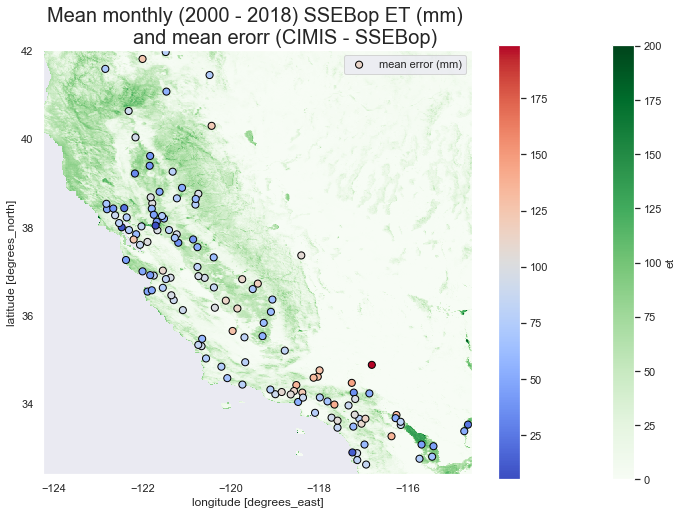

In [60]:
# Find the SSEBop mean ET and plot the errors at each site 

err_gdf = pd.merge(gdf_filt, err_df, left_on = "id", right_index = True)

files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])
et_mean = ds['et'].mean(axis = 0) # Spatial means 
et_mean = et_mean.where(et_mean!=180) # remove nans

fig, ax=plt.subplots(figsize = (12,8))
et_mean.plot(cmap = 'Greens',ax = ax)
err_gdf.plot(column = 'mean_err', markersize = 50, edgecolor = 'black', cmap = 'coolwarm',legend = True, label = "mean error (mm)", ax = ax)
plt.title('''Mean monthly (2000 - 2018) SSEBop ET (mm) 
          and mean erorr (CIMIS - SSEBop)''', size = 20)
plt.legend()
plt.show()

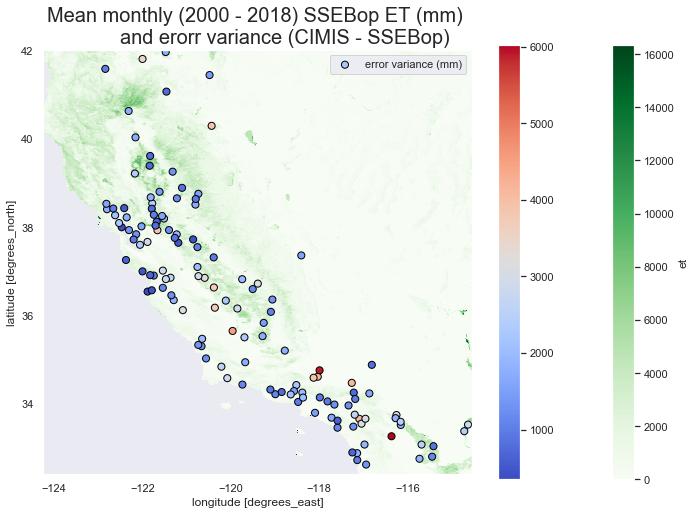

In [61]:
# Find the SSEBop mean ET and plot the error VARIANCES at each site 

err_gdf2 = pd.merge(gdf_filt, err_df, left_on = "id", right_index = True)

files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])
et_var = ds['et'].var(axis = 0) # Spatial means 
et_var = et_var.where(et_var!=1.350000e+04) # remove nans

fig, ax=plt.subplots(figsize = (12,8))
et_var.plot(cmap = 'Greens', ax = ax)
err_gdf2.plot(column = 'var_err', markersize = 50, edgecolor = 'black', cmap = 'coolwarm',legend = True, label = "error variance (mm)", ax = ax)
plt.title('''Mean monthly (2000 - 2018) SSEBop ET (mm) 
          and erorr variance (CIMIS - SSEBop)''', size = 20)
plt.legend()
plt.show()

# Apply A tempoarl bias correction 

In [17]:
# Loop through the dataset and add the monthly mean difference to each point 

outdat = []

for i in ds['et'][:]:
        
    month = pd.to_datetime(i.time.values).month
    ds_mth = i + monthly_error_mean[month-1]
    outdat.append(ds_mth)

# after the loop re-combine the DataArrays
stacked = xr.concat(outdat[:], dim="dataset")
cor_mean = stacked.mean(axis = 0) # Spatial means 
cor_plot = cor_mean.where(cor_mean!=253.28389) # remove nans

In [18]:
# Plot The Correction 

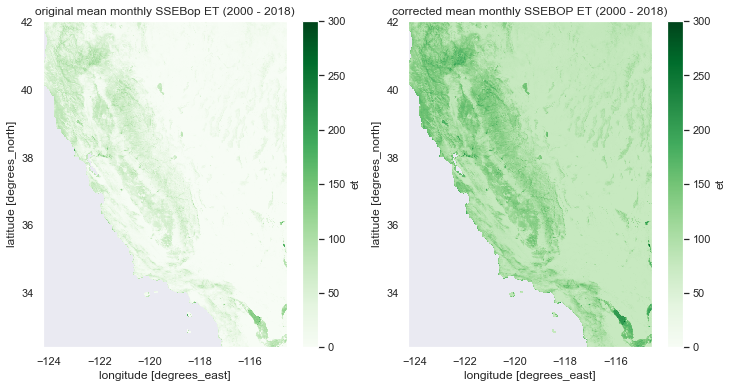

In [19]:
plt.figure(figsize = (12,6))

plt.subplot(121)
et_mean.plot(cmap = "Greens", vmin = 0, vmax= 300)
plt.title("original mean monthly SSEBop ET (2000 - 2018)")

plt.subplot(122)
cor_plot.plot(cmap = "Greens", vmin = 0, vmax= 300)
plt.title("corrected mean monthly SSEBOP ET (2000 - 2018)")

# plt.tight_layout()
plt.show()

In [70]:
# Do the same for each SSEBOP / CIMIS pair 

cor_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = gdf[gdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]
        
        cdfs = []

        # Extract lat / long value from SSEBop 
        in_lat = np.array(gdf[gdf.id==i].Latitude)
        in_lon = np.array(gdf[gdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            date = j.strftime('%Y-%m-%d')
            midx = pd.to_datetime(date).month - 1
            ssebop_et = ds.sel(time=date)['et'][lat_idx, lon_idx].values
        
            if ssebop_et == 0:
                continue
            else:            
                cor = ssebop_et + monthly_error_mean[midx]
                tempdf = pd.DataFrame([i, date, cimis_dat[j], cor]).T
                tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et_cor']

                cdfs.append(tempdf)

        if len(cdfs) == 0:
            continue
        else:
            outdfs.append(pd.concat(cdfs))
    
    cor_dfs.append(pd.concat(outdfs))



Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2000
Processing 104 CIMIS stations for 2000 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2001
Processing 108 CIMIS stations for 2001 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2002
Processing 114 CIMIS stations for 2002 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2003
Processing 113 CIMIS stations for 2003 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2004
Processing 116 CIMIS stations for 2004 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2005
Processing 119 CIMIS stations for 2005 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2006
Processing 121 CIMIS stations for 2006 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2007
Processing 119 CIMIS stations for 2007 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2008
Processing 121 CIMIS stations for 2008 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2009
Processing 123 CIMIS stations for 2009 
Processing /Users/aa

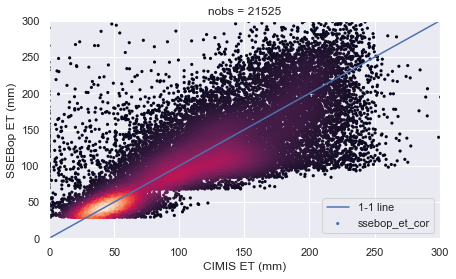

In [71]:
# Scatterplot the corrected SSEBop ET vs CIMIS et 
cordat = pd.concat(cor_dfs)

cor = cordat.dropna()
corvalid = cor[~np.isnan(cor.ssebop_et_cor.astype(float))]
corvalid = corvalid.loc[corvalid['ssebop_et_cor'] !=0].dropna()

x,y = corvalid.cimis_et.astype(float), corvalid.ssebop_et_cor.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300], label = '1-1 line')

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.xlim(0,300)
plt.ylim(0,300)
plt.legend()
plt.show()

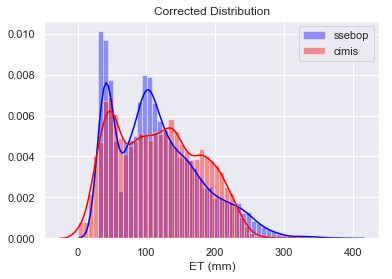

In [73]:

sns.distplot( corvalid.ssebop_et_cor.astype(float), color = "blue", label = "ssebop")
sns.distplot( corvalid.cimis_et.astype(float), color = "red", label = "cimis")
plt.title("Corrected Distribution")
plt.xlabel("ET (mm)")
plt.legend()
plt.show()


# spatiotemporal bias correction

1. calculate the monthly mean errors at each station and interpolate them across the grid.  
2. Use this estimate of error, which varies both in time and space, to perform a monthly correction on ssebop
3. Repeat without calculating the monthly mean. I.e you have a different bias correction for each date. 

In [74]:
dataset.date = pd.to_datetime(dataset.date)
dataset.set_index(dataset.date, inplace = True)
stbcor = dataset.copy()

In [75]:
cimcor = pd.merge(stbcor, gdf_filt, left_on = "id", right_on = "id", how = "inner")


In [76]:
corgrids = []

for i in cimcor.date.unique()[:]:
    
    sxrs = []
    
    sites = cimcor[cimcor.date==i]
    
    dategrid = np.zeros_like(ds['et'][0])
    dategrid[dategrid==0] = np.nan
    
    for i in sites.id.unique():
        s_t = sites[sites['id'] == i]
        # Extract lat / long value from cimis id / date
        in_lat = np.array(s_t.Latitude)
        in_lon = np.array(s_t.Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)
        
        err = s_t.cimis_et.values - s_t.ssebop_et.values        
        dategrid[lat_idx,lon_idx] = err

    cor = xr.DataArray(dategrid, coords=[lats, lons])    

    corgrids.append(cor)
    

### Sanity check the kriging of errors: 

In [77]:
# Concat the grids
biasgrids = xr.concat(corgrids[:], dim="dataset")

# Krig the first grid 
array = np.ma.masked_invalid(biasgrids[0])
xx, yy = np.meshgrid(lons, lats)
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

GD1 = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy),method='linear')
smooth = ndimage.filters.gaussian_filter(np.flipud(GD1), (3,3), mode='constant')


/anaconda3/envs/gis/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


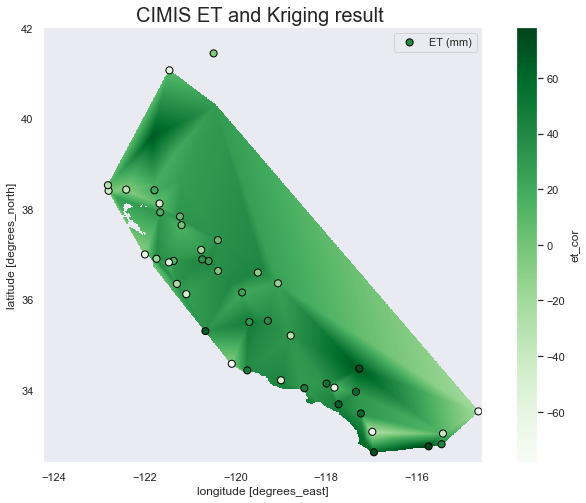

In [78]:
# Calc error 
cimcor['err'] = cimcor['cimis_et'] - cimcor['ssebop_et']
# Select first date
cimd1 = cimcor[cimcor.date == "2000-01-01"]
# Merge to gdf
cimd1.drop(['geometry'],axis = 1, inplace = True)
tgdf = pd.merge(gdf,cimd1, left_on = "id", right_on = "id", how = "left")
# Make a grid of the kriging correction
et_mean['et_cor'] = (et_mean*0) + GD1

# plot
fig, ax=plt.subplots(figsize = (12,8))
et_mean['et_cor'].plot(cmap = 'Greens', ax = ax)
tgdf.dropna().plot(column = 'err', markersize = 50, edgecolor = 'black', cmap = 'Greens',legend = True, label = "ET (mm)", ax = ax)
plt.title('''CIMIS ET and Kriging result ''', size = 20)

plt.legend()
plt.show()

### Alternatively, perform kriging directly on the ET values. I do not think this is the way to go. 

In [79]:
cimis = pd.merge(corvalid, gdf, left_on = "id", right_on = "id", how = "inner")

In [80]:
# Construct the grid with cimis data to perform the interpolation 

outgrids = []

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

for i in cimis.date.unique()[:]:
    
    sxrs = []
    
    sites = cimis[cimis.date==i]
    
    dategrid = np.zeros_like(ds['et'][0])
    dategrid[dategrid==0] = np.nan
    
    for i in sites.id.unique():
        s_t = sites[sites['id'] == i]
        # Extract lat / long value from cimis id / date
        in_lat = np.array(s_t.Latitude)
        in_lon = np.array(s_t.Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)        
        dategrid[lat_idx,lon_idx] = s_t.cimis_et.values

    cor = xr.DataArray(dategrid, coords=[lats, lons])    

    outgrids.append(cor)
    

In [81]:
cimis_grid = xr.concat(outgrids[:], dim="dataset")

In [82]:
array = np.ma.masked_invalid(cimis_grid[0])
xx, yy = np.meshgrid(lons, lats)
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

GD1 = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy),method='linear')
smooth = ndimage.filters.gaussian_filter(np.flipud(GD1), (3,3), mode='constant')


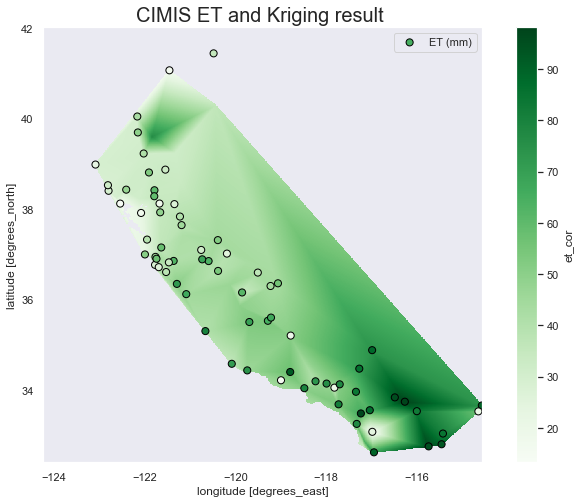

In [83]:
# Sanity Check on the kriging 

cimd1 = cimis[cimis.date == "2000-01-01"]
cimd1.drop(['geometry'],axis = 1, inplace = True)
tgdf = pd.merge(gdf,cimd1, left_on = "id", right_on = "id", how = "left")
et_mean['et_cor'] = (et_mean*0) + GD1

fig, ax=plt.subplots(figsize = (12,8))
et_mean['et_cor'].plot(cmap = 'Greens', ax = ax)
tgdf.dropna().plot(column = 'cimis_et', markersize = 50, edgecolor = 'black', cmap = 'Greens',legend = True, label = "ET (mm)", ax = ax)
plt.title('''CIMIS ET and Kriging result ''', size = 20)

plt.legend()
plt.show()

## A compromise: Monthly spatial bias correction

Compile the monthly error for each station pixel, thus maximizing number of stations and spatial coverage, and smoothing the data by averaging. Apply these 12 bias correction grids to the data and scatterplot

In [84]:
# First, make monthly mean grids from the CIMIS data that are the same dims as the ssebop data. The data at each pixel are the avg monthly error for each station. 
monthgrids = []

# Loop through months 
for i in range(1,13)[:]:
    
    # Select all sites for that month
    mdf = dataset.loc[dataset.date.dt.month == i]
    
    mdf_mean = {}
    
    # Loop through sites
    for j in mdf.id.unique()[:]:
        sdf = mdf[mdf.id == j]
        
        cim = np.nanmean(sdf.cimis_et.astype(float))
        sseb = np.nanmean(sdf.ssebop_et.astype(float))
        
        # Get the mean CIMIS ET for that site / month
        smm = np.nanmean(sdf.cimis_et.astype(float)) #  / np.nanstd(sdf.cimis_et.astype(float))
        
        # append to the dict in outer loop
        mdf_mean[int(j)] = (cim - sseb) / cim
    
    # Make dataframe for each month, drop nans, write out 
    mdf_df = pd.DataFrame(mdf_mean, index = [0]).T
    mdf_df.columns = ["et_m"]
    mdf_gdf = pd.merge(gdf,mdf_df, left_on = 'id', right_index = True)
    monthgrids.append(mdf_gdf.dropna())

/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


In [85]:
# Perform 2d kriging on each grid of errors 

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

monthcors = []

for j in monthgrids:
    
    dategrid = np.zeros_like(ds['et'][0])
    dategrid[dategrid==0] = np.nan

    for i in j.id.unique():
        s_t = j[j['id'] == i]
        # Extract lat / long value from cimis id / date
        in_lat = np.array(s_t.Latitude)
        in_lon = np.array(s_t.Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons) 
        dategrid[lat_idx,lon_idx] = s_t.et_m.values

    cor = xr.DataArray(dategrid, coords=[lats, lons])
    array = np.ma.masked_invalid(cor)
    xx, yy = np.meshgrid(lons, lats)
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    GD1 = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy),method='linear')
    
    monthcors.append(GD1)
        

In [86]:
# Apply the kriged bias corrections to the og ssebop data 

outcors = []

for i in ds['et'][:]:
        
    month = pd.to_datetime(i.time.values).month
    monthcorarr = monthcors[month-1]
    monthcorarr =  np.nan_to_num(monthcorarr,0)
    ds_mth = i + i*monthcorarr
    outcors.append(ds_mth)


In [87]:
# after the loop re-combine the DataArrays
watermask = et_mean.fillna(-999)
stacked = xr.concat(outcors[:], dim="dataset")
cor_mean = stacked.mean(axis = 0) # Spatial means 
cor_plot = cor_mean.where(watermask!=-999) # remove nans

In [88]:
relative_diff = (cor_plot - et_mean) / et_mean

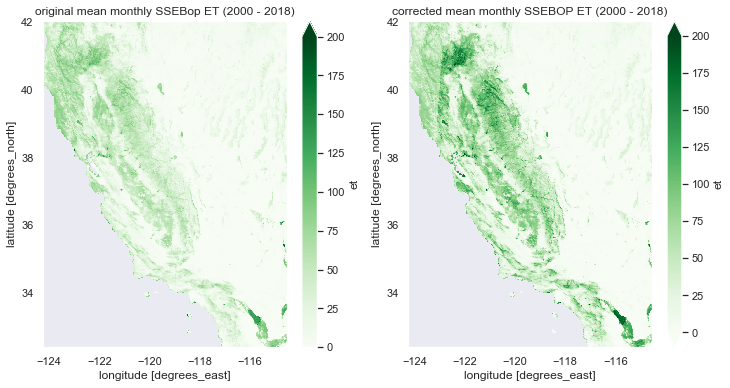

In [89]:
plt.figure(figsize = (12,6))

plt.subplot(121)
et_mean.plot(cmap = "Greens", vmin = 0, vmax= 200)
plt.title("original mean monthly SSEBop ET (2000 - 2018)")

plt.subplot(122)
cor_plot.plot(cmap = "Greens", vmin = 0, vmax= 200)
plt.title("corrected mean monthly SSEBOP ET (2000 - 2018)")

plt.show()

In [90]:
# Mask out the CVWS and hte CV, plot the correction comparison

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

In [91]:
cv = gp.read_file("/Users/aakash/Desktop/CIMIS/shape/cv.shp")
cvws = gp.read_file("/Users/aakash/Desktop/CIMIS/shape/cvws.shp")

In [92]:
ds['cvws'] = rasterize(cvws.geometry, ds['et'][0].coords)
ds['cv'] = rasterize(cv.geometry, ds['et'][0].coords)

cvws_et = ds['et']*ds['cvws']
cv_et = ds['et']*ds['cv']

In [93]:
# Apply the kriged bias corrections to the og ssebop data 

outcors_masked_cv = []
outcors_masked_cvws = []

for i in ds['et'][:]:
        
    month = pd.to_datetime(i.time.values).month
    monthcorarr = monthcors[month-1]
    monthcorarr =  np.nan_to_num(monthcorarr,0)
    
    ds_mth_cv = i*ds['cv'] + i*monthcorarr
    ds_mth_cvws = i*ds['cvws']  + i*monthcorarr
    outcors_masked_cv.append(ds_mth_cv)
    outcors_masked_cvws.append(ds_mth_cvws)


In [94]:
# after the loop re-combine the DataArrays
stacked_cv = xr.concat(outcors_masked_cv[:], dim="dataset")
stacked_cvws = xr.concat(outcors_masked_cvws[:], dim="dataset")

cor_mean_cv = stacked_cv.mean(axis = 0) # Spatial means 
cor_plot_cv = cor_mean_cv.where(watermask!=-999) # remove nans

cor_mean_cvws = stacked_cvws.mean(axis = 0) # Spatial means 
cor_plot_cvws = cor_mean_cvws.where(watermask!=-999) # remove nans

/anaconda3/envs/gis/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/anaconda3/envs/gis/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [95]:
pct_diff_cvws = abs((cvws_et.mean(axis = 0) - cor_mean_cvws) / cor_mean_cvws)
pct_diff_cv = abs((cv_et.mean(axis = 0) - cor_mean_cv) / cor_mean_cv)

/anaconda3/envs/gis/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


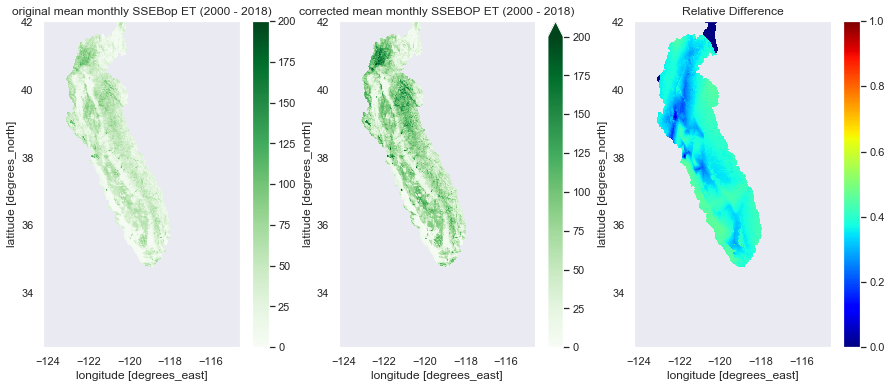

In [96]:
plt.figure(figsize = (15,6))

plt.subplot(131)
cvws_et.mean(axis = 0).plot(cmap = "Greens", vmin = 0, vmax= 200)
plt.title("original mean monthly SSEBop ET (2000 - 2018)")

plt.subplot(132)
cor_mean_cvws.plot(cmap = "Greens", vmin = 0, vmax= 200)
plt.title("corrected mean monthly SSEBOP ET (2000 - 2018)")

plt.subplot(133)
pct_diff_cvws.plot(cmap = "jet", vmin = 0, vmax = 1)
plt.title("Relative Difference")

# plt.tight_layout()
plt.show()

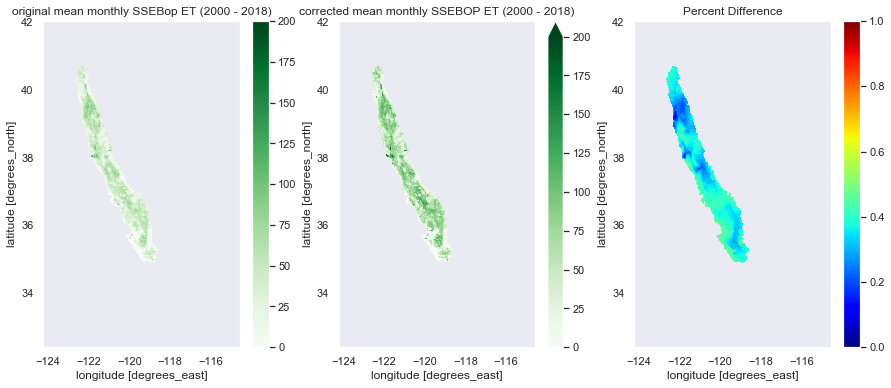

In [97]:
plt.figure(figsize = (15,6))

plt.subplot(131)
cv_et.mean(axis = 0).plot(cmap = "Greens", vmin = 0, vmax= 200)
plt.title("original mean monthly SSEBop ET (2000 - 2018)")

plt.subplot(132)
cor_mean_cv.plot(cmap = "Greens", vmin = 0, vmax= 200)
plt.title("corrected mean monthly SSEBOP ET (2000 - 2018)")

plt.subplot(133)
pct_diff_cv.plot(cmap = "jet", vmin = 0, vmax = 1)
plt.title("Percent Difference")

# plt.tight_layout()
plt.show()

In [98]:
# Get the timeseries for the original and corrections, convert mm to km 

dt = pd.date_range(ds.time[0].values, ds.time[-1].values, freq = "MS")

cv_ts= []
for i in cv_et:
    cv_ts.append(i.sum()* 1e-6 )
    
cv_ts_c= []
for i in stacked_cv:
    cv_ts_c.append(i.sum()* 1e-6 )
    
cvws_ts= []
for i in cvws_et:
    cvws_ts.append(i.sum()* 1e-6 )
    
cvws_ts_c= []
for i in stacked_cvws:
    cvws_ts_c.append(i.sum()* 1e-6 )

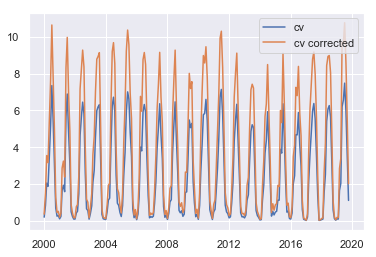

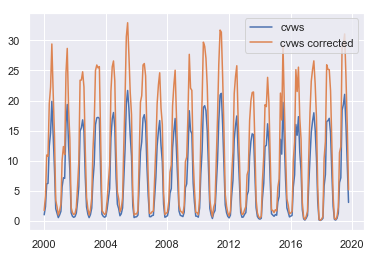

In [99]:
plt.plot(dt,np.array(cv_ts), label = "cv")
plt.plot(dt,np.array(cv_ts_c), label = "cv corrected")
plt.legend()
plt.show() 

plt.plot(dt,np.array(cvws_ts), label = "cvws")
plt.plot(dt,np.array(cvws_ts_c), label = "cvws corrected")
plt.legend()
plt.show()

In [122]:
cvws_et = pd.DataFrame([dt, np.array(cvws_ts_c)]).T
cv_et = pd.DataFrame([dt, np.array(cv_ts_c)]).T

cvws_et.to_csv("../data/ssebop_cvws_cor.csv")
cv_et.to_csv("../data/ssebop_cv_cor.csv")

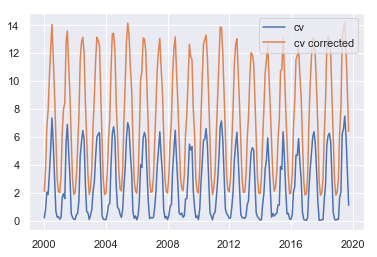

In [69]:
plt.plot(dt,np.array(cv_ts), label = "cv")
plt.plot(dt,np.array(cv_ts_c), label = "cv corrected")
plt.legend()

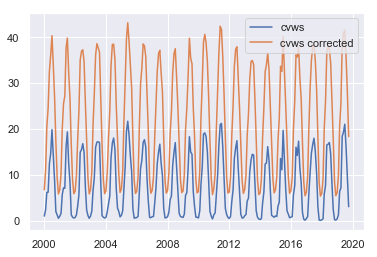

In [70]:
plt.plot(dt,np.array(cvws_ts), label = "cvws")
plt.plot(dt,np.array(cvws_ts_c), label = "cvws corrected")
plt.legend()

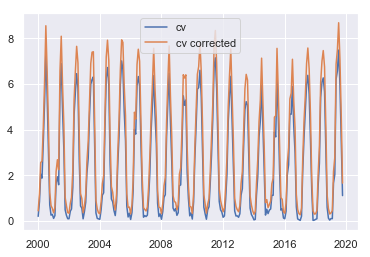

In [83]:
plt.plot(dt,np.array(cv_ts), label = "cv")
plt.plot(dt,np.array(cv_ts_c), label = "cv corrected")
plt.legend()

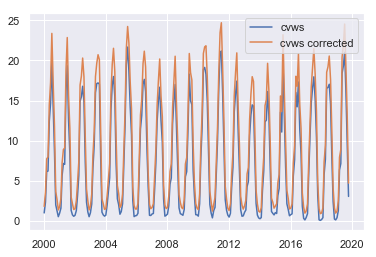

In [84]:
plt.plot(dt,np.array(cvws_ts), label = "cvws")
plt.plot(dt,np.array(cvws_ts_c), label = "cvws corrected")
plt.legend()

In [72]:
cvws_et = pd.DataFrame([dt, np.array(cvws_ts_c)]).T

In [73]:
cv_et = pd.DataFrame([dt, np.array(cv_ts_c)]).T

In [74]:
cvws_et = pd.DataFrame([dt, np.array(cvws_ts_c)]).T
cv_et = pd.DataFrame([dt, np.array(cv_ts_c)]).T

cvws_et.to_csv("../data/ssebop_cvws_cor.csv")
cv_et.to_csv("../data/ssebop_cv_cor.csv")

In [42]:
# monthgrids[2].plot(column = "et_m", legend = True)

In [43]:
# Construct the grid with cimis data to perform the interpolation 

# outgrids = []

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

dategrid = np.zeros_like(ds['et'][0])
dategrid[dategrid==0] = np.nan

for i in monthgrids[0].id.unique():
    s_t = monthgrids[0][monthgrids[0]['id'] == i]
    # Extract lat / long value from cimis id / date
    in_lat = np.array(s_t.Latitude)
    in_lon = np.array(s_t.Longitude)

    lat_idx = geo_idx(in_lat, lats)
    lon_idx = geo_idx(in_lon, lons)        
    dategrid[lat_idx,lon_idx] = s_t.et_m.values

cor = xr.DataArray(dategrid, coords=[lats, lons])    


In [110]:
array = np.ma.masked_invalid(cor)
xx, yy = np.meshgrid(lons, lats)
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

GD1 = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy),method='linear')
smooth = ndimage.filters.gaussian_filter(GD1, (5,5), mode='constant')


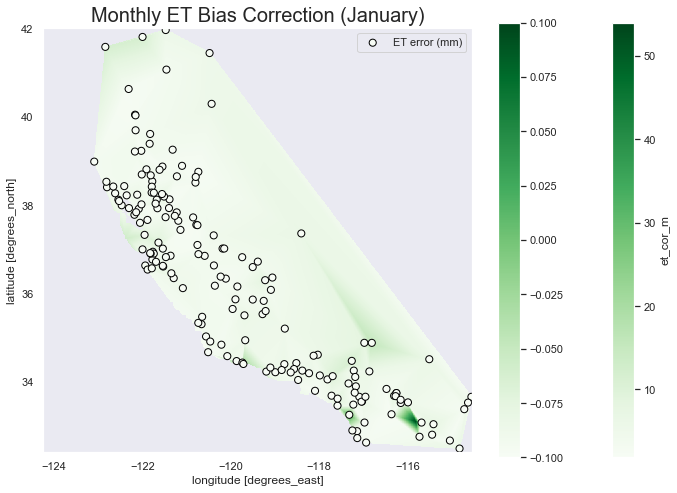

In [111]:
# Sanity check: Plot the spatial bias correction for January 
et_mean['et_cor_m'] = (et_mean*0) + GD1

fig, ax=plt.subplots(figsize = (12,8))
et_mean['et_cor_m'].plot(cmap = 'Greens', ax = ax)
monthgrids[10].plot(column = 'et_m', markersize = 50, edgecolor = 'black', cmap = 'Greens',legend = True, label = "ET error (mm)", ax = ax)
plt.title('''Monthly ET Bias Correction (January)''', size = 20)

plt.legend()
plt.show()

In [46]:
# See what a sample correction looks like: 

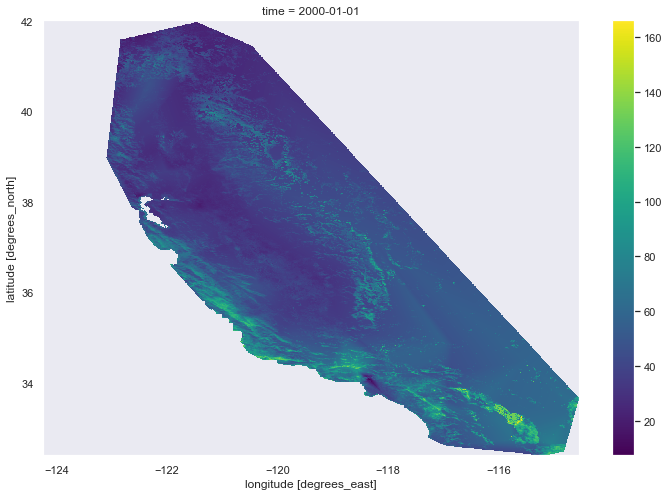

In [47]:
cort = (ds['et'][0] + et_mean['et_cor_m'])

fig, ax=plt.subplots(figsize = (12,8))
cort.plot(cmap = 'viridis', ax = ax)
plt.show()

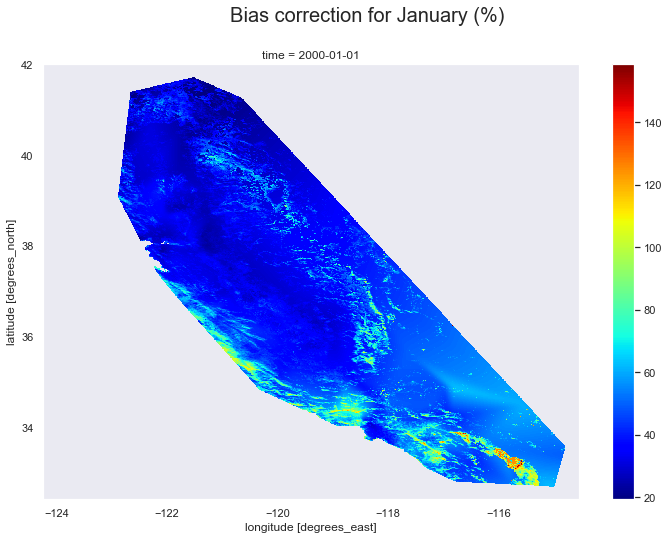

In [54]:
# What approximate percent does each pixel change? 
pct_diff = (ds['et'][0] + et_mean['et_cor_m'])

fig, ax=plt.subplots(figsize = (12,8))
plt.suptitle("Bias correction for January (%)", size = 20)
pct_diff.plot(cmap = 'jet', ax = ax)
plt.show()

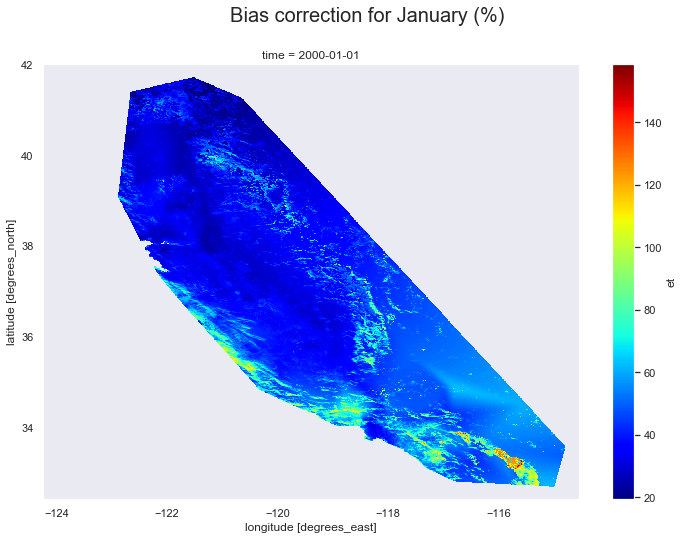

In [55]:
# What approximate percent does each pixel change? 
pct_diff = (ds['et'][0] + smooth)

fig, ax=plt.subplots(figsize = (12,8))
plt.suptitle("Bias correction for January (%)", size = 20)
pct_diff.plot(cmap = 'jet', ax = ax)
plt.show()

In [57]:
100*(np.nansum(cort.values) -  np.nansum(ds['et'][0].values)) /np.nansum(ds['et'][0].values)

496.76332539848056

In [59]:
np.nansum(ds['et'][0].values) * 4

14679536.0

In [ ]:
f = interpolate.Rbf(xx, yy, array, function='cubic')
interpolated = f(rr, cc)
plt.imshow(interpolated)
plt.colorbar()

In [293]:
# from sklearn.gaussian_process import GaussianProcessRegressor

# gp = GaussianProcessRegressor()
# gp.fit(X=np.column_stack([x1,y1]), y=newarr)
# rr_cc_as_cols = np.column_stack([x1.flatten(), y1.flatten()])
# interpolated = gp.predict(rr_cc_as_cols).reshape(newarr.shape)

# plt.imshow(interpolated)
# plt.colorbar()

In [ ]:
x1.shape

In [ ]:
import scipy as sp

# Generate KD Tree
xy = np.c_[x, y]  # X,Y data converted for use with KDTree
tree = sp.spatial.cKDTree(xy)  # Create KDtree for X,Y coordinates.

# Calculate step
distances, points = tree.query(xy, k=2)  # Query distances for X,Y points
distances = distances[:, 1:]  # Remove k=1 zero distances
step = np.mean(distances)  # Result

In [ ]:

# Generate grid
def interval(axe):
    '''Return numpy.linspace Interval for specified axe'''
    cent = axe.min() + axe.ptp() / 2  # Interval center
    nbs = np.ceil(axe.ptp() / step)  # Number of step in interval
    hwid = nbs * step / 2  # Half interval width 
    return np.linspace(cent - hwid, cent + hwid, nbs)  # linspace

xg, yg = np.meshgrid(interval(x), interval(y))  # Generate grid

# Interpolate X,Y,Z datas on grid
zg = sp.interpolate.griddata((x, y), z, (xg, yg))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = np.random.random(100)
y = np.random.random(100)
z = np.random.random(100)

# target grid to interpolate to
xi = yi = np.arange(0,1.01,0.01)
xi,yi = np.meshgrid(xi,yi)

# set mask
mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='linear')

# mask out the field
zi[mask] = np.nan

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(xi,yi,zi,np.arange(0,1.01,0.01))
plt.plot(x,y,'k.')
plt.xlabel('xi',fontsize=16)
plt.ylabel('yi',fontsize=16)

In [ ]:
import numpy as np
from scipy import interpolate

mymin,mymax = 0,3
X = np.linspace(mymin,mymax,8)
Y = np.linspace(mymin,mymax,4)

x,y = np.meshgrid(X,Y)

test = np.array([[ 1.2514318 ,  1.25145821,  1.25148472,  1.25151133],
       [ 1.25087456,  1.25090105,  1.25092764,  1.25095435],
       [ 1.25031581,  1.25034238,  1.25036907,  1.25039586],
       [ 1.24975557,  1.24978222,  1.24980898,  1.24983587]])

f = interpolate.interp2d(x,y,test,kind='cubic')

# use linspace so your new range also goes from 0 to 3, with 8 intervals
Xnew = np.linspace(mymin,mymax,8)
Ynew = np.linspace(mymin,mymax,8)

test8x8 = f(Xnew,Ynew)

plt.imshow(test8x8)

In [ ]:
x and y are locations of points - these correspond to lon and lat values of your stations;
z are the values of points - this corresponds to your temperature observations from stations;
xi and yi are target grid axes - these will be your target longitude and latitude coordinates, which must match your landmask field;
zi is the result;
This example includes a simple way to mask the field. You should replace this mask with the landmask on your grid.

In [ ]:
corvalid

In [ ]:
# Scatterplot The correction 
ds_cor = pd.concat(out_dfs)

data_cor = ds_cor.dropna()
valid_cor = data_cor[~np.isnan(data_cor.ssebop_et_cor.astype(float))]

x,y = valid_cor.cimis_et.astype(float), valid_cor.ssebop_et_cor.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
plt.plot(x, skewnorm.pdf(x, valid.ssebop_et.astype(float).sample(500)),
       'r-', lw=5, alpha=0.6, label='skewnorm pdf')

In [ ]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

rng = np.random.RandomState(0)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
bc = PowerTransformer(method='box-cox')


In [ ]:
X_trans_qt = qt.fit_transform(ssebop_arr, cimis_arr)
X_trans_bc = bc.fit_transform(ssebop_arr, cimis_arr)

In [ ]:
sns.distplot(X_trans_qt, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(X_trans_bc, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(cimis_arr, color = 'red',)
plt.show()

In [ ]:
# For days where ssebop ET is zero, set the ET equal to the CIMIS et

# Scatterplot CIMIS et vs ssebop ET 
dataset = pd.concat(all_dfs)
data = dataset.dropna()

# Drop nans
valid = data[~np.isnan(data.ssebop_et.astype(float))]
# Find ssebop zeros
cor0 = valid.cimis_et.loc[valid['ssebop_et'] == 0]
# Replace with cimis data for zero days 
mod = valid.copy()
mod['ssebop_et'][mod['ssebop_et'] == 0] = cor0

# Remove cimis zeros, since boxcox cant handle them 
modcor = mod.loc[valid['cimis_et'] != 0]

In [ ]:
# Fit distributions to the corrected data 

In [ ]:
# Format the arrays
ssebop_arr =  np.array(modcor.ssebop_et.astype(float)).reshape(modcor.shape[0],1)
cimis_arr =  np.array(modcor.cimis_et.astype(float)).reshape(modcor.shape[0],1)

# Transformt he ssebop lognormal dist
rng = np.random.RandomState(0)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
bc = PowerTransformer(method='box-cox')

# Fit
X_trans_qt = qt.fit_transform(ssebop_arr, cimis_arr)
X_trans_bc = bc.fit_transform(ssebop_arr, cimis_arr)

In [ ]:
sns.distplot(X_trans_qt, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(X_trans_bc, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(cimis_arr, color = 'red',)
plt.show()

In [ ]:
stats.rv_discrete.rvs(cor0, 100)

In [ ]:

x,y = cimis_arr.astype(float), X_trans_qt.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
plt.plot(sorted(stats.norm.ppf(x.dropna())))

In [ ]:
plt.scatter(x,y, edgecolor = 'black', alpha = 0.3)

In [ ]:
s = stats.norm.cdf(X_trans_qt)
t = s[s!=np.nan]
plt.plot(s)

In [ ]:
sns.distplot(cimis_arr)

In [ ]:
len(ssebop_arr[ssebop_arr<0])

In [ ]:
# Main routine 
cor_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = gdf[gdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]

        # Extract lat / long value from SSEBop 
        in_lat = np.array(gdf[gdf.id==i].Latitude)
        in_lon = np.array(gdf[gdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            date = j.strftime('%Y-%m-%d')
            midx = pd.to_datetime(date).month - 1
            cor = ds.sel(time=date)['et'][lat_idx, lon_idx].values+ monthly_error_mean[midx]
            tempdf = pd.DataFrame([i, yr, cimis_dat[j], cor]).T
            tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et_cor']
            
            outdfs.append(tempdf)
    
    cor_dfs.append(pd.concat(outdfs))


In [ ]:
# Scatterplot CIMIS et vs ssebop ET 
cordat = pd.concat(cor_dfs)

cor = cordat.dropna()
corvalid = cor[~np.isnan(cor.ssebop_et_cor.astype(float))]

x,y = corvalid.cimis_et.astype(float), corvalid.ssebop_et_cor.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)


In [ ]:


plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300])

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.xlim(0,300)
plt.ylim(0,300)
plt.show()

In [ ]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

In [ ]:
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize


In [ ]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

In [ ]:
# define likelihood function
def MLERegression(params):
 intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
 yhat = intercept + beta*x # predictions
# next, we flip the Bayesian question
# compute PDF of observed values normally distributed around mean (yhat)
# with a standard deviation of sd
 negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
# return negative LL
 return(negLL)

In [ ]:
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
 options={'disp': True})

In [ ]:
results

In [ ]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf.head(2), 4)

In [ ]:
plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300])

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.xlim(0,300)
plt.ylim(0,300)
plt.show()

In [ ]:
for i in range(0,12):
    print(monthly_error_mean[i] * monthly_error_std[i] / len(gdf))

In [ ]:
len(gdf)

In [ ]:
# Plot dists of all observations 

In [ ]:
x =  valid.ssebop_et.astype(float)+ 0.00001
x_grid = np.linspace(np.min(x), np.max(x), 1000)
kde = stats.gaussian_kde(x, bw_method=0.5 / x.std(ddof=1))
pdf = kde.evaluate(x_grid)

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=1)
plt.title("")
plt.xlim(0,20)
plt.show()

In [ ]:
plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=1)
plt.title("")
# plt.xlim(-1,8)
plt.show()

In [ ]:
sns.distplot(valid.ssebop_et.astype(float), kde = False, fit=stats.lognorm) #log normal distribution

In [ ]:
sns.kdeplot(valid.cimis_et.astype(float),valid.ssebop_et.astype(float),shade=True,shade_lowest = False)
plt.ylim(0,25)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

arr = np.log(np.array(valid.ssebop_et.astype(float)).reshape(-1,1) + 0.0000001)

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(arr) 

X=np.linspace(0,50,1000)[:, np.newaxis]

log_density_values=kde.score_samples(X)
density=np.exp(log_density_values)
plt.plot(X,density)

In [ ]:
# Plot the distribution of the log of the nonzero SSEBop ET values
arr = valid.ssebop_et.astype(float)+ 0.0000000001
arr = np.log(data.loc[data['ssebop_et'] != 0].ssebop_et.astype(float))

log_x = (arr  - np.mean(arr)) / np.var(arr)
sns.distplot(log_x.dropna())

In [ ]:
X = valid.ssebop_et.astype(float) + 0.000000001
μ1 = np.mean(valid.ssebop_et.astype(float))
μ2 = np.mean(valid.cimis_et.astype(float))
σ1 = np.std(valid.ssebop_et.astype(float))
σ2 = np.std(valid.cimis_et.astype(float))

transformed = (μ2 + (X - μ1 )) / (σ1/σ2)
sns.distplot(transformed, bins = 30)
sns.distplot(valid.cimis_et.astype(float), bins = 30)

In [ ]:
# sns.distplot(valid.ssebop_et.astype(float), color = 'red')
sns.distplot(transformed, color= 'blue', bins = 30)

In [ ]:
# Scatterplot CIMIS et vs ssebop ET 
mask = transformed>120
data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]

x,y = valid.cimis_et.astype(float)[mask], transformed[mask]
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
# Scale the transformed data to cimis min / max 
normed = (transformed-min(data.cimis_et.astype(float)))/(max(data.cimis_et.astype(float))-min(data.cimis_et.astype(float)))

# Scatterplot CIMIS et vs ssebop ET 
mask = transformed>120
data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]

x,y = valid.cimis_et.astype(float)[mask], normed[mask]
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
# Calc the CIMIS distribution 

nparam_density_func = stats.kde.gaussian_kde(data.cimis_et.astype(float))
x = np.linspace(-20, 300, 1000)
nparam_density = nparam_density_func(x)

loc_param, scale_param = stats.norm.fit(data.cimis_et.astype(float))
param_density = stats.norm.pdf(x, loc=loc_param, scale=scale_param)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data.cimis_et.astype(float), bins=30, normed=True)
ax.plot(x, nparam_density, 'r-', label='non-parametric density (smoothed by Gaussian kernel)')
ax.plot(x, param_density, 'k--', label='parametric density')
ax.legend(loc='best')

In [ ]:
from scipy.interpolate import interp1d
fit = interp1d(data.ssebop_et.astype(float), data.cimis_et.astype(float))
sdf = fit(data.ssebop_et.astype(float))[~np.isnan(t(data.ssebop_et.astype(float)))]
sns.distplot(sdf)
sns.distplot(data.cimis_et.astype(float))

In [ ]:
x,y = valid.cimis_et.astype(float)[~np.isnan(fit(valid.ssebop_et.astype(float)))], sdf
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
# Plot mean monthly statistics for each dataset, and monthly error 

dataset = pd.concat(all_dfs)

dataset.date = pd.to_datetime(dataset.date)

monthly_error_mean = []
monthly_error_std =[]
monthly_ssebop_mean = []
monthly_ssebop_std = []
monthly_cimis_mean = []
monthly_cimis_std = []

for i in range(1,13):
    # Select all rows for month i 
    mdf = dataset.loc[dataset['date'].dt.month==i]
    
    # Get cimis / ssebop stats 
    monthly_ssebop_mean.append(np.nanmean(mdf.ssebop_et))
    monthly_ssebop_std.append(np.nanstd(mdf.ssebop_et))
    monthly_cimis_mean.append(np.nanmean(mdf.cimis_et))
    monthly_cimis_std.append(np.nanstd(mdf.cimis_et))
    
    mresid = mdf.cimis_et - mdf.ssebop_et
    monthly_error_mean.append(np.nanmean(mresid))
    monthly_error_std.append(np.nanstd(mresid))

# +- 1 std
upper = np.array(monthly_error_mean) + np.array(monthly_error_std)
lower = np.array(monthly_error_mean) - np.array(monthly_error_std)

cimis_upper = np.array(monthly_cimis_mean) + np.array(monthly_cimis_mean)
cimis_lower = np.array(monthly_cimis_mean) - np.array(monthly_cimis_mean)

ssebop_upper = np.array(monthly_ssebop_mean) + np.array(monthly_ssebop_std)
ssebop_lower = np.array(monthly_ssebop_mean) - np.array(monthly_ssebop_std)


plt.plot(monthly_cimis_mean, label = 'mean cimis')
plt.fill_between(range(0,12),cimis_lower, cimis_upper, alpha = 0.3)

plt.plot(monthly_ssebop_mean, label = 'mean ssebop')
plt.fill_between(range(0,12),ssebop_lower, ssebop_upper, alpha = 0.3)

plt.plot(monthly_error_mean, label = 'mean error')
plt.fill_between(range(0,12),lower, upper, alpha = 0.3)
plt.ylabel("ET (mm)")
plt.title("Monthly mean / std SSEBOP / CIMIS ET")
plt.xlabel("month")
plt.legend()
plt.show()

In [ ]:
monthly_ssebop